In [1]:
import pandas as pd
import glob
import os
import librosa
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Loading data

## Annotations

In [2]:
elan_annotation_paths = ['../annotations/surf.txt']
praat_annotation_paths = ['../annotations/lavina_class.TextGrid',
                          '../annotations/dtp.TextGrid',
                          '../annotations/artem_vps.TextGrid',
                          '../annotations/dima_arxiv.TextGrid',
                          '../annotations/sasha_code.TextGrid',
                          '../annotations/gomes.TextGrid',
                          '../annotations/ksenia.TextGrid',
                          '../annotations/dashka.TextGrid',
                          '../annotations/cursach1.TextGrid']

In [3]:
def get_elan_annotations(paths):
    dfs = []
    for path in paths:
        df = pd.read_csv(path, sep='\t', header=None)
        df = df[[3, 5, 7, 8]]
        df = df.rename(columns={3: 'start', 5: 'finish', 7: 'length', 8: 'label'})
        dfs.append(df)
    return dfs

In [4]:
elan_annotations = get_elan_annotations(elan_annotation_paths)

In [5]:
elan_annotations[-1].head()

,start,finish,length,label
0,0.018,144.237,144.219,c
1,146.801,147.044,0.243,a
2,150.407,150.600,0.193,b
3,152.654,152.968,0.314,a
4,154.260,154.705,0.445,a


In [6]:
def get_praat_annotations(paths):
    dfs = []
    for path in paths:
        with open(path) as f:
            annotation = [l.strip() for l in f.readlines()]
            
        indxs = [i for i, l in enumerate(annotation) if l == '"IntervalTier"']
        annotation = annotation[indxs[0] + 5:indxs[1] if len(indxs) > 1\
                                else len(annotation)]
        annotation_dicts = []

        for s, e, l in zip(annotation[0::3], annotation[1::3], annotation[2::3]):
            annotation_dicts.append({
                'start': float(s),
                'finish': float(e),
                'label': l.replace('"', ''),
                'length': float(e) - float(s)
            })
        df = pd.DataFrame(annotation_dicts)
        dfs.append(df)
    return dfs

In [7]:
praat_annotations = get_praat_annotations(praat_annotation_paths)

In [8]:
praat_annotations[-1].head()

,finish,label,length,start
0,17.252199,,17.252199,0.000000
1,17.472705,a,0.220506,17.252199
2,40.094541,,22.621836,17.472705
3,40.370174,a,0.275633,40.094541
4,44.799067,,4.428893,40.370174


In [9]:
praat_annotations[1].head()

,finish,label,length,start
0,37.323779,,37.323779,0.000000
1,37.647123,a,0.323345,37.323779
2,130.266718,,92.619594,37.647123
3,130.571042,b,0.304325,130.266718
4,130.792946,,0.221903,130.571042


In [10]:
annotations = elan_annotations.copy()
annotations.extend(praat_annotations)

## Audio

In [11]:
audio_paths = [
    '../audio/surf.m4a',
    '../audio/lavina_class.m4a',
    '../audio/dtp.m4a',
    '../audio/artem_vps.m4a',
    '../audio/dima_arxiv.m4a',
    '../audio/sasha_code.m4a',
    '../audio/gomes.m4a',
    '../audio/ksenia.m4a',
    '../audio/dashka.m4a',
    '../audio/cursach1.3gpp'
]

In [12]:
def get_audios(paths):    
    res = []
    for path in paths:
        audio, sr = librosa.load(path)
        res.append(audio)
    return res, sr

def get_label_data(annotation, audio, label, sr):
    start_samples_indxs = librosa.time_to_samples(annotation[annotation.label ==\
                                                              label].start.values, sr)
    finish_samples_indxs = librosa.time_to_samples(annotation[annotation.label ==\
                                                               label].finish.values, sr)
    
    data = []
    for s, f in zip(start_samples_indxs, finish_samples_indxs):
        data.append(audio[np.arange(s, f)])
    return data

def get_unlabel_data(annotation, audio, labels, sr):
    start_samples_indxs = librosa.time_to_samples(\
                          annotation[annotation.label.isin(labels)].start.values, sr)
    finish_samples_indxs = librosa.time_to_samples(\
                           annotation[annotation.label.isin(labels)].finish.values, sr)
    finish_samples_indxs = np.hstack([[0], finish_samples_indxs])
    start_samples_indxs = np.hstack([start_samples_indxs, [len(start_samples_indxs) - 1]])
    
    data = []
    for s, f in zip(finish_samples_indxs, start_samples_indxs):
        data.append(audio[np.arange(s, f)])
    return data

In [13]:
# audios, sr = get_audios(audio_paths[-1:])
audios, sr = get_audios(audio_paths)

## Demo examples of classes

In [23]:
data_a = get_label_data(annotations[-1], audios[-1], 'a', sr)
merged_data_a = np.hstack(data_a)
librosa.output.write_wav('../demo/label_a_tmp.wav', merged_data_a, sr)

In [24]:
data_a = get_label_data(annotations[-1], audios[-1], 'b', sr)
merged_data_a = np.hstack(data_a)
librosa.output.write_wav('../demo/label_b_tmp.wav', merged_data_a, sr)

In [57]:
data_a = get_unlabel_data(annotations[2], audios[2], ['a', 'b'], sr)
merged_data_a = np.hstack(data_a)
librosa.output.write_wav('../demo/label_c_tmp.wav', merged_data_a, sr)

## Creating dataset

In [14]:
interval_time = 0.3
interval_len = librosa.time_to_samples(interval_time)[0]

# step_time = 0.05
# step_len = librosa.time_to_samples(step_time)[0]

In [15]:
interval_len

6615

In [16]:
def get_label_data(annotation, audio, labels, sr=22050):
    data = []
    targets = []
    addings = []
    
    label_map = {'a': 0, 'b': 1, 'c': 2}
    for label in labels:
        l = label_map[label]
        start_samples_indxs = librosa.time_to_samples(annotation[annotation.label ==\
                                                              label].start.values, sr)
        finish_samples_indxs = librosa.time_to_samples(annotation[annotation.label ==\
                                                               label].finish.values, sr)
        for s, f in zip(start_samples_indxs, finish_samples_indxs):
            n = f - s
            if n >= interval_len:
                data.append(np.array(audio[s:s + interval_len]))
                addings.append(0)
            elif n < interval_len:
                data.append(np.pad(audio[s:f], (0, interval_len - n), 'mean')) # wrap
                addings.append(interval_len - n)
            targets.append(l)
    return data, targets, addings

In [17]:
d, t, a = get_label_data(annotations[-1], audios[-1], ['a', 'b'])

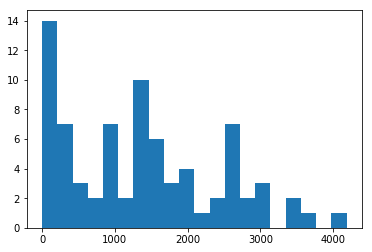

In [18]:
plt.hist(a, bins=20);

In [19]:
pd.Series.value_counts(t)

0    69
1     8
dtype: int64

In [20]:
set([len(dd) for dd in d])

{6615}

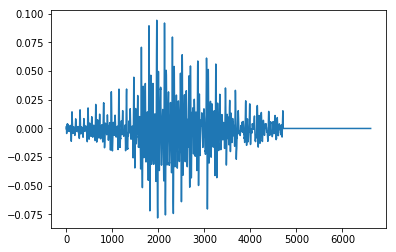

In [21]:
plt.plot(d[-2])

In [22]:
from IPython.display import Audio

In [23]:
wid = Audio(d[-2], rate=22050)

display(wid)

In [24]:
def get_unlabel_data(annotation, audio, labels, additions, sr=22050):
    data = []

    start_samples_indxs = librosa.time_to_samples(\
                          annotation[~annotation.label.isin(labels)].start.values, sr)
    finish_samples_indxs = librosa.time_to_samples(\
                           annotation[~annotation.label.isin(labels)].finish.values, sr)
    for s, f in zip(start_samples_indxs, finish_samples_indxs):
        n = f - s
        i = 0
        while n > interval_len:
            crop = np.array(audio[s + i * interval_len:s + (i + 1) * interval_len])
            # because random value 0 is bad for slicing, set minimum value 1
#             sl = max(int(np.random.exponential(exp_dist_scale)), 1)
            # limit maximum random value by 70% of interval_len
#             sl = min(sl, int(interval_len * max_crop_percent))

            # another version - better
            sl = np.random.choice(additions)
            if sl != 0:
                crop = crop[:-sl]
                crop = np.pad(crop, (0, sl), 'mean')
            data.append(crop)
            n -= interval_len
            i += 1
    targets = [2] * len(data)
    return data, targets

In [25]:
len(annotations), len(audios)

(10, 10)

## Dataset

In [26]:
X, y = [], []
X_c = []
additions = []

labels_map = {
    'a': 0,
    'b': 1,
    'c': 2
}

for ann, aud in zip(annotations, audios):
    data, targets, adds = get_label_data(ann, aud, ['a', 'b'])
    X.extend(data)
    y.extend(targets)
    additions.extend(adds)
    
for ann, aud in zip(annotations, audios):
    data, targets = get_unlabel_data(ann, aud, ['a', 'b'], additions)
    X_c.extend(data)

c_indxs = np.random.choice(range(len(X_c)), len(X_c) // 2, replace=False)
X.extend(np.array(X_c)[c_indxs].tolist())
y.extend([2] * (len(X_c) // 2))

In [27]:
len(X), len(y)

(10986, 10986)

In [28]:
pd.Series.value_counts(y)

2    10041
0      667
1      278
dtype: int64

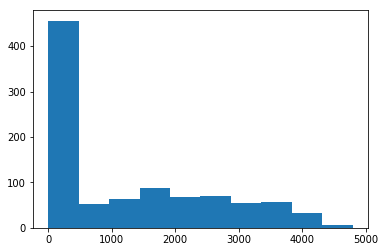

In [29]:
plt.hist(additions);

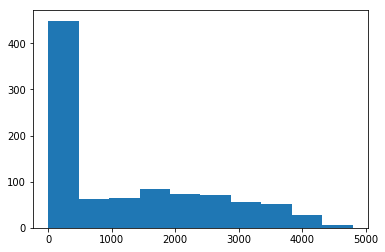

In [30]:
plt.hist(np.random.choice(additions, len(additions)));

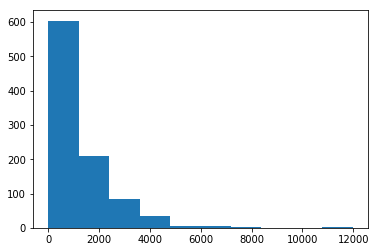

In [31]:
plt.hist(np.random.exponential(np.mean(additions), len(additions)));

### Shuffle

In [32]:
import random

In [33]:
temp = list(zip(X, y))
random.shuffle(temp)
X, y = zip(*temp)

### Pickle

In [34]:
import pickle
import gzip

In [35]:
with gzip.open('../cache/dataset.pkl.gz', 'wb') as f:
    pickle.dump([X, y], f)

In [36]:
sr

22050